# Central Differential Privacy (Server-Side Clipping)



Central DP on server-side approach consists of two separate phases: 
> 1. clipping of the updates
> 2. adding noise to the aggregated model. 

For the clipping phase, Flower framework has made it possible to decide whether to perform clipping on the `server side` or the `client side`.



This approach has the advantage of the server enforcing uniform clipping across all clients’ updates and reducing the communication overhead for clipping values. However, it also has the disadvantage of increasing the computational load on the server due to the need to perform the clipping operation for all clients.

For central DP with server-side clipping, there are two Strategy classes that act as wrappers around the actual Strategy instance (for example in our case, FedAvg). 

The two wrapper classes are:
> 1. `DifferentialPrivacyServerSideFixedClipping` for fixed clipping
> 2. `DifferentialPrivacyServerSideAdaptiveClipping` for adaptive clipping.

<br><p>

## CNN: DifferentialPrivacyServerSideFixedClipping

Here, we'll focus on running our experiment with `DifferentialPrivacyServerSideFixedClipping`

<br><p>

----

In [1]:
%load_ext autoreload
%load_ext watermark
    
%autoreload 2
%watermark --python -p torch,flwr

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.1.0

torch: 2.6.0
flwr : 1.18.0



--------

## Loading Dependencies

In [ ]:
import os
import sys
sys.path.append("../..")

import ray
import time

import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

from logging import ERROR

from flwr.common import ndarrays_to_parameters, Context 
from flwr.client import Client, ClientApp
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import DifferentialPrivacyServerSideFixedClipping, FedAvg
from flwr.simulation import run_simulation

from src.config import ExperimentName
from src.paths import RAY_LOG_DIR
from src.FL_client import MedicalImageClient
from src.FL_server import weighted_average, build_evaluate_fn
from src.local_utility import load_yaml_config, set_device, prepare_FL_dataset, get_weights

from src.tracker import reset_base_memory_csv

In [ ]:
# Replace with appropritate values
data_name_ = "alzheimer" #"skin_lesions"  #
base_type_ = "cnn"           
num_labels_ = 4 #Alzheimer-4 & skin_lesions-8 classlabels
exp_name_ = "CDP-SF"
experiment_name_ = ExperimentName.FL_CDP_SF_CNN

In [ ]:
DEVICE = set_device()
reset_base_memory_csv() 

fed_config = load_yaml_config(key="experiments", item_name=ExperimentName.FL_CDP_SF_CNN)
client_dataloaders = prepare_FL_dataset(exp_name= exp_name_, data_name=data_name_, base_type=base_type_, augment_data=True)

In [ ]:
def client_fn(context: Context) -> Client:
    """
    Creates and initializes a federated learning client.

    This function initializes a client in the federated learning setup by 
    assigning a unique partitioned dataset and a machine learning model 
    for training and validation.

    Args:
        context (Context): The execution context containing client-specific configurations.

    Returns:
        Client: A configured federated learning client ready to participate in training.
    """
    partition_id = int(context.node_config["partition-id"]) #<--- Get the client partition ID
    
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_labels_)

    # Assign partitioned client dataset
    train_loader, val_loader, test_loader = client_dataloaders[partition_id]
    
    return MedicalImageClient(model, train_loader, val_loader, exp_name=exp_name_, data_name = data_name_, base_type=base_type_, client_id=partition_id).to_client()

client = ClientApp(client_fn)

In [ ]:
def server_fn(context: Context):
    """
    Creates and configures the federated learning server using the FedAvg strategy.

    This function initializes the federated learning server with a FedAvg strategy,
    specifying the parameters for client participation in training and evaluation,
    the global model evaluation function, and the metric aggregation function.

    Args:
        context (Context): The execution context for the federated learning server.

    Returns:
        ServerAppComponents: A configured server application with the defined strategy
        and server settings.
    """
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_labels_)
    params = ndarrays_to_parameters(get_weights(model))
    
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,                 #<--- Sample 100% of available clients for training
        fraction_evaluate=1.0,            #<--- Sample 100% of available clients for evaluation
        initial_parameters=params,        #<--- Initial model parameters
        evaluate_fn=build_evaluate_fn(    #<--- Global evaluation function
            exp_name = exp_name_, 
            base_type = base_type_,
            data_name=data_name_, 
            experiment_item=experiment_name_, 
            num_labels=num_labels_
            ),
        evaluate_metrics_aggregation_fn=weighted_average,  #<-- pass the metric aggregation function
    )
    
    # Wrap the strategy with the DifferentialPrivacyServerSideFixedClipping wrapper
    dp_strategy = DifferentialPrivacyServerSideFixedClipping(
        strategy= strategy,
        noise_multiplier= 0.001, #0.001,
        num_sampled_clients=fed_config.get("num_clients"),
        clipping_norm=0.1 #1e-4
        )
    
    # Configure the server with the specified number of federated rounds
    sever_config = ServerConfig(num_rounds=fed_config['num_rounds']) #<--- no. of federated rounds
    
    return ServerAppComponents(strategy = dp_strategy, config = sever_config)

# Wrap the server function in a ServerApp, and instantiate it
server = ServerApp(server_fn = server_fn) 

----- 

Set up our backend configurations before running the simulation

> - `init_args`: filter logging coming from the Simulation Engine so it's more readable in notebooks
> - `client_resources`: by default, allocate to each client 1x CPU and 0x GPUs. However, when running on GPU, assign an entire GPU for each client

In [6]:
backend_setup = {
    "init_args": {
        "logging_level": ERROR, 
        "log_to_driver": fed_config.get("log_to_driver")
    },
    "client_resources": {
        "num_cpus": fed_config.get("num_cpus"), 
        "num_gpus": fed_config.get("num_gpus")            
    },
}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda": 
    backend_setup["client_resources"] = {"num_cpus": 1, "num_gpus": 1.0}

--- 

## Initiate the Simulation 

Initiate the simulation by passing the server and client apps, and specify the number of supernodes that will be selected on every round. 

2025-05-04 17:50:18,558	INFO worker.py:1771 -- Started a local Ray instance.
2025-05-04 17:50:18,898	INFO packaging.py:530 -- Creating a file package for local directory '/home/emeka/PrivacyBench'.
2025-05-04 17:50:19,323	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_8034838f7344d6da.zip' (16.62MiB) to Ray cluster...
2025-05-04 17:50:19,374	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_8034838f7344d6da.zip'.
2025-05-04 17:50:20,474 - DEBUG - Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=20, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
[codecarbon WARNING @ 17:50:20] Multiple instances of codecarbon are allowed to run at the same time.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning

(ClientAppActor pid=172747) 
(ClientAppActor pid=172747) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172747) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172747) ⏱️ Total training time: 0 minutes 23 seconds
(ClientAppActor pid=172748) 


(ClientAppActor pid=172747) Seed set to 42
(raylet) [2025-05-04 17:50:57,492 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 847876096; capacity: 52589998080. Object creation will fail if spilling is required.
(ClientAppActor pid=172747) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172747) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172747)   self.pid = os.fork()
(raylet) [2025-05-04 17:51:07,502 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 847839232; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 17:51:17,513 E 170843 170883] (raylet) file_system_monito

(ClientAppActor pid=172747) 
(ClientAppActor pid=172747) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=172747) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=172747) ⏱️ Total training time: 0 minutes 22 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (1, nan, {'accuracy': 0.134375}, 58.12609108900142)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=172747) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172747) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172747)   self.pid = os.fork()
INFO :      ag

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=172747) 
(ClientAppActor pid=172747) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172747) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172747) ⏱️ Total training time: 0 minutes 22 seconds


(ClientAppActor pid=172747) Seed set to 42
(ClientAppActor pid=172747) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172747) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172747)   self.pid = os.fork()
(raylet) [2025-05-04 17:51:57,556 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 847937536; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 17:52:07,566 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 847933440; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=172747) 
(ClientAppActor pid=172747) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172747) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172747) ⏱️ Total training time: 0 minutes 21 seconds


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (2, nan, {'accuracy': 0.134375}, 110.37939959400137)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=172747) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172747) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172747)   self.pid = os.fork()
(raylet) [202

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=172747) 


(ClientAppActor pid=172748) Seed set to 42
(ClientAppActor pid=172748) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172748) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172748)   self.pid = os.fork()
(raylet) [2025-05-04 17:52:47,608 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 847912960; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 17:52:57,617 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 847908864; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster]
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 21 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
(raylet) [2025-05-04 17:53:07,627 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 847872000; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      fit progress: (3, 1.7331762850284576, {'accuracy': 0.35859375}, 162.43530786000156)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=172

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=172747) 
(ClientAppActor pid=172747) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172747) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172747) ⏱️ Total training time: 0 minutes 22 seconds


(ClientAppActor pid=172748) Seed set to 42
(ClientAppActor pid=172748) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172748) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172748)   self.pid = os.fork()
(raylet) [2025-05-04 17:53:37,663 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 847548416; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 17:53:47,675 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 847532032; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 21 seconds


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
(raylet) [2025-05-04 17:53:57,686 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 847536128; capacity: 52589998080. Object creation will fail if spilling is required.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (4, 1.7211742281913758, {'accuracy': 0.35859375}, 214.17111289200147)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=172

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=172747) 


(ClientAppActor pid=172748) Seed set to 42
(ClientAppActor pid=172748) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172748) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172748)   self.pid = os.fork()
(raylet) [2025-05-04 17:54:27,717 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 847155200; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 17:54:37,728 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 847151104; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 17:54:47,739 E 170843 170883] (raylet) file_system_monito

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster]
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (5, nan, {'accuracy': 0.134375}, 266.6948897910006)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=172747) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172747) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172747)   self.pid = os.fork()
INFO :      ag

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=172747) 
(ClientAppActor pid=172747) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172747) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172747) ⏱️ Total training time: 0 minutes 23 seconds


(ClientAppActor pid=172748) Seed set to 42
(ClientAppActor pid=172748) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172748) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172748)   self.pid = os.fork()
(raylet) [2025-05-04 17:55:27,780 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 846856192; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 17:55:37,792 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 846839808; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggre

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 21 seconds


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (6, nan, {'accuracy': 0.134375}, 319.33422940200035)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=172747) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172747) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172747)   self.pid = os.fork()
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
IN

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=172747) 


(ClientAppActor pid=172748) Seed set to 42
(ClientAppActor pid=172748) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172748) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172748)   self.pid = os.fork()
(raylet) [2025-05-04 17:56:17,837 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 846745600; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 17:56:27,848 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 846450688; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster]
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (7, nan, {'accuracy': 0.134375}, 371.9972389620016)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(raylet) [2025-05-04 17:56:37,856 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 846458880; capacity: 52589998080. Object creation will fail if spilling is required.
(ClientAppActor pid=172747) /home/emeka/.

(ClientAppActor pid=172747) 
(ClientAppActor pid=172747) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172747) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172747) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 23 seconds


(ClientAppActor pid=172747) Seed set to 42
(ClientAppActor pid=172747) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172747) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172747)   self.pid = os.fork()
(raylet) [2025-05-04 17:57:07,886 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 846405632; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 17:57:17,896 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 846372864; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=172747) 
(ClientAppActor pid=172747) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172747) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172747) ⏱️ Total training time: 0 minutes 21 seconds


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
(raylet) [2025-05-04 17:57:27,906 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 846200832; capacity: 52589998080. Object creation will fail if spilling is required.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (8, nan, {'accuracy': 0.134375}, 425.36447300800137)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=172747) /home/emeka/

(ClientAppActor pid=172747) 
(ClientAppActor pid=172747) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172747) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172747) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=172748) 


(ClientAppActor pid=172747) Seed set to 42
(ClientAppActor pid=172747) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172747) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172747)   self.pid = os.fork()
(raylet) [2025-05-04 17:57:57,938 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 846163968; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 17:58:07,948 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 846131200; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 17:58:17,960 E 170843 170883] (raylet) file_system_monito

(ClientAppActor pid=172747) 
(ClientAppActor pid=172747) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster]
(ClientAppActor pid=172747) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=172747) ⏱️ Total training time: 0 minutes 22 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (9, nan, {'accuracy': 0.134375}, 478.07318919000136)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=172747) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172747) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172747)   self.pid = os.fork()
INFO :      a

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=172747) 
(ClientAppActor pid=172747) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172747) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172747) ⏱️ Total training time: 0 minutes 23 seconds


(ClientAppActor pid=172748) Seed set to 42
(ClientAppActor pid=172748) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172748) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172748)   self.pid = os.fork()
(raylet) [2025-05-04 17:58:58,001 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 845881344; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 17:59:08,012 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 845873152; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (10, nan, {'accuracy': 0.134375}, 531.169381914)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=172747) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172747) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172747)   self.pid = os.fork()
(raylet) [2025-05

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 23 seconds
(ClientAppActor pid=172747) 


(ClientAppActor pid=172748) Seed set to 42
(ClientAppActor pid=172748) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172748) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172748)   self.pid = os.fork()
(raylet) [2025-05-04 17:59:48,055 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 845541376; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 17:59:58,064 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 845520896; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster]
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
(raylet) [2025-05-04 18:00:08,074 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 845488128; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      fit progress: (11, 1.650798535346985, {'accuracy': 0.35859375}, 583.9458749670011)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=1727

(ClientAppActor pid=172747) 
(ClientAppActor pid=172747) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172747) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172747) ⏱️ Total training time: 0 minutes 23 seconds
(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 23 seconds


(ClientAppActor pid=172747) Seed set to 42
(ClientAppActor pid=172747) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172747) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172747)   self.pid = os.fork()
(raylet) [2025-05-04 18:00:38,107 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 845242368; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 18:00:48,118 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 845238272; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 18:00:58,128 E 170843 170883] (raylet) file_system_monito

(ClientAppActor pid=172747) 
(ClientAppActor pid=172747) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172747) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172747) ⏱️ Total training time: 0 minutes 22 seconds


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (12, 1.647695744037628, {'accuracy': 0.35859375}, 637.182686909)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=172747) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172747) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172747)   self.pid = os.fork()
INFO :      aggregate_evaluate: received 3 results and 0 failures
INF

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 23 seconds
(ClientAppActor pid=172747) 


(ClientAppActor pid=172748) Seed set to 42
(ClientAppActor pid=172748) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172748) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172748)   self.pid = os.fork()
(raylet) [2025-05-04 18:01:38,171 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 844828672; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 18:01:48,181 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 844812288; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster]
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (13, 1.632121455669403, {'accuracy': 0.35859375}, 689.9682439400003)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=172747) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172747) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172747)   self.pid = os.fork

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 23 seconds
(ClientAppActor pid=172747) 
(ClientAppActor pid=172747) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172747) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172747) ⏱️ Total training time: 0 minutes 23 seconds


(ClientAppActor pid=172748) Seed set to 42
(ClientAppActor pid=172748) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172748) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172748)   self.pid = os.fork()
(raylet) [2025-05-04 18:02:28,226 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 844398592; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 18:02:38,239 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 844390400; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
(raylet) [2025-05-04 18:02:48,249 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 844333056; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      fit progress: (14, 1.6290685772895812, {'accuracy': 0.35859375}, 743.2673694180012)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=172

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=172747) 


(ClientAppActor pid=172748) Seed set to 42
(ClientAppActor pid=172748) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172748) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172748)   self.pid = os.fork()
(raylet) [2025-05-04 18:03:18,280 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 844197888; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 18:03:28,292 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 844017664; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster]
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 21 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
(raylet) [2025-05-04 18:03:38,301 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 844029952; capacity: 52589998080. Object creation will fail if spilling is required.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (15, 1.6242662608623504, {'accuracy': 0.35859375}, 796.060014273)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=172747)

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=172747) 
(ClientAppActor pid=172747) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172747) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172747) ⏱️ Total training time: 0 minutes 23 seconds


(ClientAppActor pid=172748) Seed set to 42
(ClientAppActor pid=172748) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172748) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172748)   self.pid = os.fork()
(raylet) [2025-05-04 18:04:08,334 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 843816960; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 18:04:18,345 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 843784192; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 18:04:28,356 E 170843 170883] (raylet) file_system_monito

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (16, 1.6147755444049836, {'accuracy': 0.35859375}, 848.6314173219998)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=172747) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172747) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172747)   self.pid = os.fork()
INFO :      aggregate_evaluate: received 3 results and 0 failure

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=172747) 


(ClientAppActor pid=172748) Seed set to 42
(ClientAppActor pid=172748) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172748) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172748)   self.pid = os.fork()
(raylet) [2025-05-04 18:05:08,399 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 843186176; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 18:05:18,409 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 843169792; capacity: 52589998080. Object creation will fail if spilling is required.


(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster]
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (17, 1.6055204033851624, {'accuracy': 0.35859375}, 901.3003879010012)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=172747) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172747) is multi-threaded, use of fork() may lead to deadlocks 

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=172747) 
(ClientAppActor pid=172747) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172747) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172747) ⏱️ Total training time: 0 minutes 22 seconds


(ClientAppActor pid=172748) Seed set to 42
(ClientAppActor pid=172748) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172748) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172748)   self.pid = os.fork()
(raylet) [2025-05-04 18:05:58,450 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 842866688; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 18:06:08,460 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 842842112; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggre

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 21 seconds


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
(raylet) [2025-05-04 18:06:18,469 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 842792960; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      fit progress: (18, 1.6017636120319367, {'accuracy': 0.35859375}, 954.2169167650009)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=172747) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=172747) 


(ClientAppActor pid=172748) Seed set to 42
(ClientAppActor pid=172748) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172748) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172748)   self.pid = os.fork()
(raylet) [2025-05-04 18:06:48,499 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 842584064; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 18:06:58,508 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 842592256; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggre

(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster]
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 22 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
(raylet) [2025-05-04 18:07:08,518 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 842539008; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (19, 1.5961930811405183, {'accuracy': 0.35859375}, 1006.8537458850005)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=172748) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_6

(ClientAppActor pid=172747) 
(ClientAppActor pid=172747) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172747) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172747) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=172748) 
(ClientAppActor pid=172748) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172748) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172748) ⏱️ Total training time: 0 minutes 23 seconds


(raylet) [2025-05-04 18:07:38,548 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 842182656; capacity: 52589998080. Object creation will fail if spilling is required.
(ClientAppActor pid=172747) Seed set to 42
(ClientAppActor pid=172747) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=172747) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=172747)   self.pid = os.fork()
(raylet) [2025-05-04 18:07:48,559 E 170843 170883] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_17-50-15_535960_170505 is over 95% full, available space: 842108928; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 18:07:58,568 E 170843 170883] (raylet) file_system_monito

(ClientAppActor pid=172747) 
(ClientAppActor pid=172747) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=172747) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=172747) ⏱️ Total training time: 0 minutes 21 seconds


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=170505) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()



 ___________________________________________________________________________________________________
ExperimentName.FL_CDP_SF_CNN Model Final Evaluation 

Test Accuracy: 35.86% | Precision: 0.13 | Recall: 0.36 | F1-Score: 0.19 | ROC-AUC: 0.45 | MCC: 0.00
 


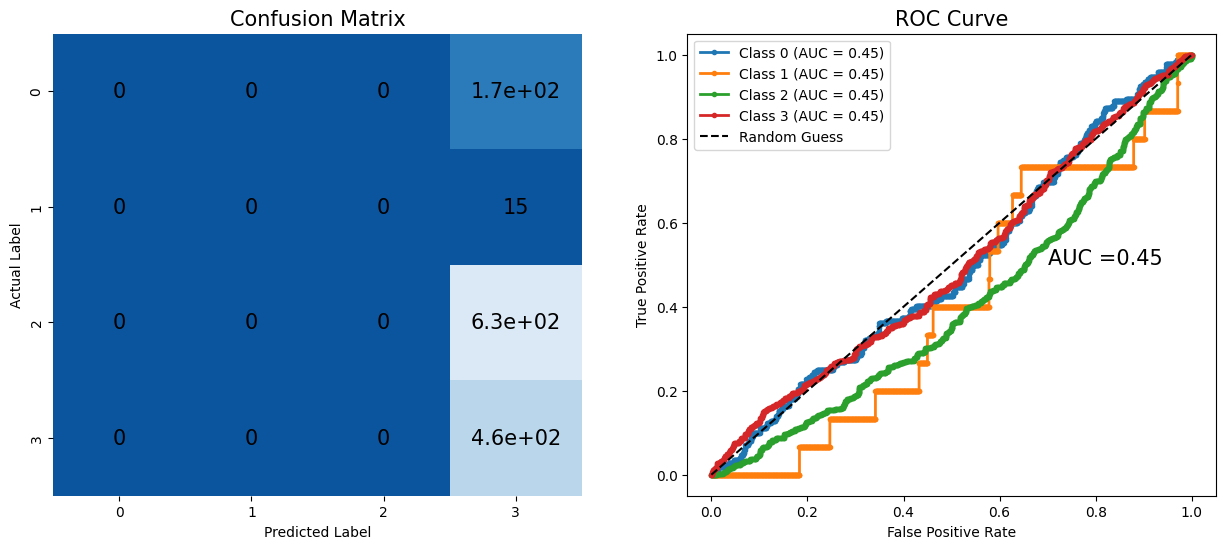


 ___________________________________________________________________________________________________
ExperimentName.FL_CDP_SF_CNN Model Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       172
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00       634
           3       0.36      1.00      0.53       459

    accuracy                           0.36      1280
   macro avg       0.09      0.25      0.13      1280
weighted avg       0.13      0.36      0.19      1280

___________________________________________________________________________________________________

📊 Consolidated Metrics:
⏱️ Total Duration: 1393.19 sec
✅ Total Energy: 0.05637 kWh
🌍 Total CO₂ Emitted: 0.02424 kg
🧠 Peak CPU RAM: 0.00 GB
🖥️ Peak GPU VRAM: 0.97 GB

 ___________________________________________________________________________________________________


/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le


🕒 Total Time: 17 min 53 sec


In [ ]:
project_root =  os.path.abspath("../../")

ray.shutdown()

ray.init(
    _temp_dir=str(RAY_LOG_DIR),
    runtime_env={
        "env_vars": {
            "PYTHONWARNINGS": "ignore::DeprecationWarning",  # More specific warning filter
            "OMP_NUM_THREADS": "1"  # Prevents thread oversubscription
        },
        "working_dir": project_root,
        'excludes': ['data', '.cache', '.docker', '.local', 'logs/model']
    },
    ignore_reinit_error=True
)

start_time = time.perf_counter()

run_simulation(
    server_app = server,
    client_app = client,
    num_supernodes = fed_config.get("num_clients"),
    backend_config=backend_setup
)


end_time = time.perf_counter()
duration = end_time - start_time
print(f"\n🕒 Total Time: {duration // 60:.0f} min {duration % 60:.0f} sec")

ray.shutdown()